# KLSE Stock Screener & Analyzer

## Introduction

Welcome to the KLSE (Bursa Malaysia) Stock Screener project! This notebook will teach you how to:
- Fetch real-time and historical Malaysian stock data
- Analyze fundamental metrics (PE ratio, market cap, dividends)
- Calculate technical indicators (RSI, MACD, Moving Averages)
- Build a stock screening system with custom filters
- Track and analyze portfolio performance
- Compare stocks across sectors

### What You'll Learn:
1. **Data Acquisition**: Using yfinance API for Malaysian stocks
2. **Fundamental Analysis**: Evaluating company financials and metrics
3. **Technical Analysis**: Implementing and interpreting indicators
4. **Stock Screening**: Building filters to find investment opportunities
5. **Portfolio Management**: Tracking multiple stocks and calculating returns
6. **Data Visualization**: Creating professional charts and dashboards

### About Malaysian Stock Market (KLSE):
- **Exchange**: Bursa Malaysia (formerly known as Kuala Lumpur Stock Exchange - KLSE)
- **Index**: FTSE Bursa Malaysia KLCI (FBM KLCI) - tracks top 30 companies
- **Ticker Format**: Stock codes use `.KL` suffix (e.g., `1155.KL` for Maybank)
- **Currency**: Malaysian Ringgit (MYR)
- **Trading Hours**: 
  - Morning session: 9:00 AM - 12:30 PM MYT
  - Afternoon session: 2:30 PM - 5:00 PM MYT

### Prerequisites:
- Basic Python knowledge
- Understanding of pandas DataFrames
- Basic knowledge of stock market concepts (helpful but not required)

Let's begin! 🚀

## 1. Setup and Imports

First, we'll import all the necessary libraries:

- **yfinance**: Fetches stock data from Yahoo Finance (free and legal!)
- **pandas**: Data manipulation and analysis
- **pandas_ta**: Technical analysis indicators
- **matplotlib & seaborn**: Static visualizations
- **plotly**: Interactive charts
- **datetime**: Date handling

**Installation Note**: If you haven't installed the packages yet:
```bash
pip install yfinance pandas pandas-ta matplotlib seaborn plotly
```

In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print("✅ All libraries imported successfully!")
print(f"📅 Today's date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"📊 yfinance version: {yf.__version__}")

✅ All libraries imported successfully!
📅 Today's date: 2025-11-13
📊 yfinance version: 0.2.66


### Malaysian Stock Ticker Format

**Important**: Malaysian stocks on Yahoo Finance use the `.KL` suffix:

| Company | Stock Code | Yahoo Finance Ticker |
|---------|------------|----------------------|
| Maybank | 1155 | `1155.KL` |
| Tenaga Nasional | 5296 | `5296.KL` |
| Public Bank | 1295 | `1295.KL` |
| CIMB Group | 1023 | `1023.KL` |
| Petronas Chemicals | 5183 | `5183.KL` |

The **KLSE index** itself is accessed with: `^KLSE`

## 2. Basic Stock Data Fetching

Let's start by fetching data for one Malaysian stock to understand the data structure.

We'll use **Maybank (1155.KL)**, one of Malaysia's largest banks.

In [2]:
# Fetch Maybank stock data
maybank_ticker = "1155.KL"
maybank = yf.Ticker(maybank_ticker)

# Get historical price data for the last 1 year
maybank_hist = maybank.history(period="1y")

print(f"📈 Historical Data for Maybank ({maybank_ticker})")
print("="*80)
print(f"Data points: {len(maybank_hist)} days")
print(f"Date range: {maybank_hist.index[0].strftime('%Y-%m-%d')} to {maybank_hist.index[-1].strftime('%Y-%m-%d')}")
print("\nFirst 5 rows:")
maybank_hist.head()

📈 Historical Data for Maybank (1155.KL)
Data points: 245 days
Date range: 2024-11-13 to 2025-11-13

First 5 rows:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-13 00:00:00+08:00,9.856634,9.856634,9.762583,9.800203,3269900,0.0,0.0
2024-11-14 00:00:00+08:00,9.819014,9.837825,9.668531,9.687342,10771400,0.0,0.0
2024-11-15 00:00:00+08:00,9.724962,9.743772,9.668530,9.743772,13010100,0.0,0.0
2024-11-18 00:00:00+08:00,9.706151,9.762583,9.649721,9.724962,8958700,0.0,0.0
2024-11-19 00:00:00+08:00,9.687341,9.706151,9.630910,9.630910,11017500,0.0,0.0


### Understanding OHLCV Data

The historical data contains these columns:

- **Open**: Opening price for the day
- **High**: Highest price during the day
- **Low**: Lowest price during the day
- **Close**: Closing price for the day (most commonly used)
- **Volume**: Number of shares traded
- **Dividends**: Dividend payments (if any)
- **Stock Splits**: Stock split information (if any)

**Note**: All prices are in Malaysian Ringgit (MYR)

In [3]:
# Let's check the basic statistics
print("📊 Price Statistics for Maybank (Last Year):")
print("="*80)
print(f"Current Price: RM {maybank_hist['Close'][-1]:.2f}")
print(f"52-Week High: RM {maybank_hist['High'].max():.2f}")
print(f"52-Week Low: RM {maybank_hist['Low'].min():.2f}")
print(f"Average Daily Volume: {maybank_hist['Volume'].mean():,.0f} shares")
print(f"\nPrice Change (1Y): {((maybank_hist['Close'][-1] / maybank_hist['Close'][0] - 1) * 100):.2f}%")

📊 Price Statistics for Maybank (Last Year):
Current Price: RM 9.95
52-Week High: RM 10.15
52-Week Low: RM 9.04
Average Daily Volume: 11,245,580 shares

Price Change (1Y): 1.53%


In [4]:
# Create a reusable function to fetch stock data
def get_stock_data(ticker, period="1y"):
    """
    Fetch historical stock data for a Malaysian stock.
    
    Parameters:
    -----------
    ticker : str
        Malaysian stock ticker (e.g., '1155.KL' for Maybank)
    period : str
        Time period: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'max'
    
    Returns:
    --------
    pd.DataFrame
        Historical price data
    """
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period)
        
        if hist.empty:
            print(f"❌ No data found for {ticker}")
            return None
        
        print(f"✅ Fetched {len(hist)} days of data for {ticker}")
        return hist
    
    except Exception as e:
        print(f"❌ Error fetching {ticker}: {e}")
        return None

# Test the function
print("Testing get_stock_data function:\n")
tenaga_data = get_stock_data("5296.KL", period="6mo")
if tenaga_data is not None:
    print(f"\nTenaga Nasional current price: RM {tenaga_data['Close'][-1]:.2f}")

Testing get_stock_data function:

✅ Fetched 126 days of data for 5296.KL

Tenaga Nasional current price: RM 1.59


## 3. Fundamental Data Analysis

Now let's fetch fundamental data - the key financial metrics that investors use to evaluate companies.

### Key Fundamental Metrics:

- **Market Cap**: Total value of all shares (company size)
- **PE Ratio**: Price-to-Earnings ratio (valuation metric)
- **EPS**: Earnings Per Share (profitability)
- **Dividend Yield**: Annual dividend as % of stock price
- **Sector**: Industry classification
- **Beta**: Stock volatility relative to market

In [5]:
# Fetch fundamental data for Maybank
maybank_info = maybank.info

# Extract key metrics
fundamentals = {
    'Company': maybank_info.get('longName', 'N/A'),
    'Sector': maybank_info.get('sector', 'N/A'),
    'Industry': maybank_info.get('industry', 'N/A'),
    'Market Cap': f"RM {maybank_info.get('marketCap', 0) / 1e9:.2f}B",
    'PE Ratio': maybank_info.get('trailingPE', 'N/A'),
    'Forward PE': maybank_info.get('forwardPE', 'N/A'),
    'EPS': maybank_info.get('trailingEps', 'N/A'),
    'Dividend Yield': f"{maybank_info.get('dividendYield', 0) * 100:.2f}%" if maybank_info.get('dividendYield') else 'N/A',
    'Beta': maybank_info.get('beta', 'N/A'),
    '52W High': f"RM {maybank_info.get('fiftyTwoWeekHigh', 0):.2f}",
    '52W Low': f"RM {maybank_info.get('fiftyTwoWeekLow', 0):.2f}"
}

print("📊 MAYBANK FUNDAMENTAL DATA")
print("="*80)
for key, value in fundamentals.items():
    print(f"{key:<20}: {value}")

📊 MAYBANK FUNDAMENTAL DATA
Company             : Malayan Banking Berhad
Sector              : Financial Services
Industry            : Banks - Regional
Market Cap          : RM 120.21B
PE Ratio            : 11.705882
Forward PE          : 11.436781
EPS                 : 0.85
Dividend Yield      : 604.00%
Beta                : 0.096
52W High            : RM 10.76
52W Low             : RM 9.32


In [6]:
# Create a function to fetch fundamentals for any stock
def get_fundamentals(ticker):
    """
    Fetch fundamental data for a Malaysian stock.
    
    Parameters:
    -----------
    ticker : str
        Malaysian stock ticker
    
    Returns:
    --------
    dict
        Dictionary containing fundamental metrics
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        fundamentals = {
            'Ticker': ticker,
            'Name': info.get('longName', ticker),
            'Sector': info.get('sector', 'N/A'),
            'Industry': info.get('industry', 'N/A'),
            'Market Cap (B)': info.get('marketCap', 0) / 1e9 if info.get('marketCap') else None,
            'PE Ratio': info.get('trailingPE'),
            'Forward PE': info.get('forwardPE'),
            'EPS': info.get('trailingEps'),
            'Dividend Yield (%)': info.get('dividendYield', 0) * 100 if info.get('dividendYield') else None,
            'Beta': info.get('beta'),
            'Current Price': info.get('currentPrice') or info.get('regularMarketPrice'),
            '52W High': info.get('fiftyTwoWeekHigh'),
            '52W Low': info.get('fiftyTwoWeekLow')
        }
        
        return fundamentals
    
    except Exception as e:
        print(f"❌ Error fetching fundamentals for {ticker}: {e}")
        return None

print("✅ get_fundamentals() function created!")

✅ get_fundamentals() function created!


In [7]:
# Let's compare fundamentals of multiple blue-chip Malaysian stocks
blue_chips = [
    "1155.KL",  # Maybank
    "1295.KL",  # Public Bank
    "5296.KL",  # Tenaga Nasional
    "1023.KL",  # CIMB Group
    "5183.KL",  # Petronas Chemicals
    "3816.KL",  # IHH Healthcare
    "4197.KL",  # Maxis
    "5225.KL",  # Axiata Group
]

print("Fetching fundamental data for blue-chip stocks...\n")

fundamentals_list = []
for ticker in blue_chips:
    data = get_fundamentals(ticker)
    if data:
        fundamentals_list.append(data)

# Create DataFrame for easy comparison
fundamentals_df = pd.DataFrame(fundamentals_list)

print("\n📊 BLUE-CHIP STOCKS COMPARISON")
print("="*80)
fundamentals_df[['Name', 'Sector', 'Market Cap (B)', 'PE Ratio', 'Dividend Yield (%)']].head(10)

Fetching fundamental data for blue-chip stocks...




📊 BLUE-CHIP STOCKS COMPARISON


,Name,Sector,Market Cap (B),PE Ratio,Dividend Yield (%)
0,Malayan Banking Berhad,Financial Services,120.205033,11.705882,604.0
1,Public Bank Berhad,Financial Services,83.465978,11.621622,504.0
2,Mr D.I.Y. Group (M) Berhad,Consumer Cyclical,15.069188,26.500002,375.0
3,CIMB Group Holdings Berhad,Financial Services,81.540145,10.661972,520.0
4,PETRONAS Chemicals Group Berhad,Basic Materials,28.000000,NaN,170.0
5,MISC Berhad,Industrials,34.594030,32.291668,465.0
6,Sime Darby Berhad,Consumer Cyclical,14.108287,6.900000,634.0
7,IHH Healthcare Berhad,Healthcare,72.898265,33.000000,121.0


## 4. Technical Indicators

Technical analysis uses historical price and volume data to predict future movements.

### Common Technical Indicators:

1. **Moving Averages (SMA)**:
   - SMA-20: Short-term trend (20 days)
   - SMA-50: Medium-term trend (50 days)
   - SMA-200: Long-term trend (200 days)

2. **RSI (Relative Strength Index)**:
   - Measures momentum (0-100 scale)
   - >70 = Overbought (may drop)
   - <30 = Oversold (may rise)

3. **MACD (Moving Average Convergence Divergence)**:
   - Trend-following momentum indicator
   - Signal line crossovers indicate buy/sell signals

4. **Bollinger Bands**:
   - Volatility indicator
   - Price near upper band = overbought
   - Price near lower band = oversold

In [8]:
# Fetch more data for technical analysis (we need at least 200 days for SMA-200)
ticker = "1155.KL"  # Maybank
df = get_stock_data(ticker, period="1y")

if df is not None:
    # Calculate technical indicators using pandas_ta
    
    # 1. Simple Moving Averages
    df['SMA_20'] = df.ta.sma(length=20)
    df['SMA_50'] = df.ta.sma(length=50)
    df['SMA_200'] = df.ta.sma(length=200)
    
    # 2. RSI (Relative Strength Index)
    df['RSI'] = df.ta.rsi(length=14)
    
    # 3. MACD
    macd = df.ta.macd()
    if macd is not None:
        df = pd.concat([df, macd], axis=1)
    
    # 4. Bollinger Bands
    bbands = df.ta.bbands(length=20)
    if bbands is not None:
        df = pd.concat([df, bbands], axis=1)
    
    print("✅ Technical indicators calculated!\n")
    print("📊 Latest Values:")
    print("="*80)
    print(f"Current Price: RM {df['Close'][-1]:.2f}")
    print(f"SMA-20: RM {df['SMA_20'][-1]:.2f}")
    print(f"SMA-50: RM {df['SMA_50'][-1]:.2f}")
    print(f"SMA-200: RM {df['SMA_200'][-1]:.2f}")
    print(f"RSI: {df['RSI'][-1]:.2f}")
    
    # Interpret RSI
    rsi_value = df['RSI'][-1]
    if rsi_value > 70:
        rsi_signal = "🔴 OVERBOUGHT (may be due for correction)"
    elif rsi_value < 30:
        rsi_signal = "🟢 OVERSOLD (may be undervalued)"
    else:
        rsi_signal = "🟡 NEUTRAL"
    
    print(f"RSI Signal: {rsi_signal}")

✅ Fetched 245 days of data for 1155.KL


✅ Technical indicators calculated!

📊 Latest Values:
Current Price: RM 9.95
SMA-20: RM 9.91
SMA-50: RM 9.88
SMA-200: RM 9.68
RSI: 57.15
RSI Signal: 🟡 NEUTRAL


In [9]:
# Display the last few rows with all indicators
print("📈 Recent data with technical indicators:\n")
display_cols = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD_12_26_9', 'MACDs_12_26_9']
available_cols = [col for col in display_cols if col in df.columns]
df[available_cols].tail(10)

📈 Recent data with technical indicators:



,Close,SMA_20,SMA_50,RSI,MACD_12_26_9,MACDs_12_26_9
Date,,,,,,
2025-10-31 00:00:00+08:00,9.87,9.9210,9.801570,49.725002,0.015300,0.031076
2025-11-03 00:00:00+08:00,9.95,9.9185,9.810856,58.536873,0.018944,0.028649
2025-11-04 00:00:00+08:00,9.95,9.9150,9.819754,58.536873,0.021584,0.027236
2025-11-05 00:00:00+08:00,9.92,9.9135,9.828051,54.390784,0.021012,0.025991
2025-11-06 00:00:00+08:00,9.92,9.9095,9.836737,54.390784,0.020325,0.024858
2025-11-07 00:00:00+08:00,9.91,9.9050,9.844835,52.941131,0.018758,0.023638
2025-11-10 00:00:00+08:00,9.94,9.9045,9.852562,56.671918,0.019709,0.022852
2025-11-11 00:00:00+08:00,9.91,9.9035,9.861630,52.214014,0.017836,0.021849
2025-11-12 00:00:00+08:00,9.94,9.9045,9.870522,55.945943,0.018559,0.021191


In [10]:
# Create a reusable function to add all technical indicators
def add_technical_indicators(df):
    """
    Add comprehensive technical indicators to price data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Historical price data with OHLCV columns
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with added technical indicators
    """
    df = df.copy()
    
    # Helper function to safely extract Series from pandas_ta results
    def safe_add_indicator(result):
        if result is None:
            return None
        elif isinstance(result, pd.Series):
            return result
        elif isinstance(result, pd.DataFrame):
            # If DataFrame returned, take the first column
            return result.iloc[:, 0] if len(result.columns) > 0 else None
        return result
    
    # Moving Averages with safe extraction
    df['SMA_20'] = safe_add_indicator(df.ta.sma(length=20))
    df['SMA_50'] = safe_add_indicator(df.ta.sma(length=50))
    df['SMA_200'] = safe_add_indicator(df.ta.sma(length=200))
    df['EMA_20'] = safe_add_indicator(df.ta.ema(length=20))
    
    # RSI
    df['RSI'] = safe_add_indicator(df.ta.rsi(length=14))
    
    # MACD
    macd = df.ta.macd()
    if macd is not None:
        df = pd.concat([df, macd], axis=1)
    
    # Bollinger Bands
    bbands = df.ta.bbands(length=20, std=2)
    if bbands is not None:
        df = pd.concat([df, bbands], axis=1)
    
    # ATR (Average True Range) - Volatility
    df['ATR'] = safe_add_indicator(df.ta.atr(length=14))
    
    # Volume SMA
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    
    return df

print("✅ add_technical_indicators() function created!")
print("\nThis function adds:")
print("  • Simple Moving Averages (20, 50, 200)")
print("  • Exponential Moving Average (20)")
print("  • RSI (14-day)")
print("  • MACD with signal line")
print("  • Bollinger Bands")
print("  • ATR (Average True Range)")
print("  • Volume Moving Average")

✅ add_technical_indicators() function created!

This function adds:
  • Simple Moving Averages (20, 50, 200)
  • Exponential Moving Average (20)
  • RSI (14-day)
  • MACD with signal line
  • Bollinger Bands
  • ATR (Average True Range)
  • Volume Moving Average


## 5. Stock Screener Functionality

Now let's build a stock screener - a tool to filter stocks based on specific criteria.

### Common Screening Criteria:

1. **Value Investing**: Low PE ratio, high dividend yield
2. **Growth Stocks**: High revenue/earnings growth
3. **Large Cap**: Market cap > RM 10B
4. **Technical Momentum**: Price above moving averages, RSI in healthy range

We'll create a flexible screener that you can customize!

In [11]:
# Define a comprehensive list of Malaysian stocks to screen
# This includes top companies from various sectors
KLSE_STOCKS = {
    # Banking & Finance
    '1155.KL': 'Maybank',
    '1295.KL': 'Public Bank',
    '1023.KL': 'CIMB Group',
    '6947.KL': 'RHB Bank',
    '1066.KL': 'Hong Leong Bank',
    
    # Utilities
    '5296.KL': 'Tenaga Nasional',
    
    # Oil & Gas / Petrochemicals
    '5183.KL': 'Petronas Chemicals',
    '5225.KL': 'Petronas Gas',
    '2445.KL': 'Dialog Group',
    
    # Telecommunications
    '4197.KL': 'Maxis',
    '6012.KL': 'Axiata Group',
    '4863.KL': 'DiGi.Com',
    
    # Healthcare
    '3816.KL': 'IHH Healthcare',
    
    # Plantation
    '2518.KL': 'Sime Darby Plantation',
    '5285.KL': 'Kuala Lumpur Kepong',
    '2445.KL': 'IOI Corporation',
    
    # Construction & Property
    '1961.KL': 'Gamuda',
    '5205.KL': 'SP Setia',
    
    # Consumer
    '3816.KL': 'Nestle Malaysia',
    '2836.KL': 'Dutch Lady Milk',
    
    # Technology
    '5235.KL': 'Inari Amertron'
}

print(f"📋 Stock Universe: {len(KLSE_STOCKS)} Malaysian stocks")
print("\nSectors covered:")
print("  • Banking & Finance")
print("  • Utilities")
print("  • Oil & Gas / Petrochemicals")
print("  • Telecommunications")
print("  • Healthcare")
print("  • Plantation")
print("  • Construction & Property")
print("  • Consumer Goods")
print("  • Technology")

📋 Stock Universe: 19 Malaysian stocks

Sectors covered:
  • Banking & Finance
  • Utilities
  • Oil & Gas / Petrochemicals
  • Telecommunications
  • Healthcare
  • Plantation
  • Construction & Property
  • Consumer Goods
  • Technology


In [12]:
# Fetch fundamentals for all stocks in our universe
print("Fetching fundamental data for all stocks...")
print("This may take a minute...\n")

all_fundamentals = []

for ticker, name in KLSE_STOCKS.items():
    print(f"Fetching {name} ({ticker})...")
    data = get_fundamentals(ticker)
    if data:
        all_fundamentals.append(data)

# Create master DataFrame
stocks_df = pd.DataFrame(all_fundamentals)

print(f"\n✅ Successfully fetched data for {len(stocks_df)} stocks")
print("\n📊 Preview:")
stocks_df[['Name', 'Sector', 'Market Cap (B)', 'PE Ratio', 'Dividend Yield (%)']].head()

Fetching fundamental data for all stocks...
This may take a minute...

Fetching Maybank (1155.KL)...
Fetching Public Bank (1295.KL)...
Fetching CIMB Group (1023.KL)...
Fetching RHB Bank (6947.KL)...


Fetching Hong Leong Bank (1066.KL)...
Fetching Tenaga Nasional (5296.KL)...
Fetching Petronas Chemicals (5183.KL)...


Fetching Petronas Gas (5225.KL)...
Fetching IOI Corporation (2445.KL)...
Fetching Maxis (4197.KL)...


Fetching Axiata Group (6012.KL)...
Fetching DiGi.Com (4863.KL)...


Fetching Nestle Malaysia (3816.KL)...
Fetching Sime Darby Plantation (2518.KL)...


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 2518.KL"}}}


Fetching Kuala Lumpur Kepong (5285.KL)...
Fetching Gamuda (1961.KL)...


Fetching SP Setia (5205.KL)...
Fetching Dutch Lady Milk (2836.KL)...


Fetching Inari Amertron (5235.KL)...


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 5235.KL"}}}



✅ Successfully fetched data for 19 stocks

📊 Preview:


,Name,Sector,Market Cap (B),PE Ratio,Dividend Yield (%)
0,Malayan Banking Berhad,Financial Services,120.205033,11.705882,604.0
1,Public Bank Berhad,Financial Services,83.465978,11.621622,504.0
2,CIMB Group Holdings Berhad,Financial Services,81.540145,10.661972,520.0
3,Celcomdigi Berhad,Communication Services,42.468057,30.166666,415.0
4,RHB Bank Berhad,Financial Services,30.097205,9.324325,624.0


In [13]:
# Create a comprehensive stock screener function
def screen_stocks(df, 
                  min_market_cap=None, 
                  max_pe=None,
                  min_dividend_yield=None,
                  sectors=None):
    """
    Screen stocks based on fundamental criteria.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with stock fundamental data
    min_market_cap : float
        Minimum market cap in billions (e.g., 5 for RM 5B)
    max_pe : float
        Maximum PE ratio (e.g., 15 for value stocks)
    min_dividend_yield : float
        Minimum dividend yield in % (e.g., 3 for 3%)
    sectors : list
        List of sectors to include (e.g., ['Financial Services', 'Technology'])
    
    Returns:
    --------
    pd.DataFrame
        Filtered stocks meeting the criteria
    """
    filtered = df.copy()
    
    # Apply filters
    if min_market_cap is not None:
        filtered = filtered[filtered['Market Cap (B)'] >= min_market_cap]
    
    if max_pe is not None:
        filtered = filtered[filtered['PE Ratio'].notna()]
        filtered = filtered[filtered['PE Ratio'] <= max_pe]
        filtered = filtered[filtered['PE Ratio'] > 0]  # Exclude negative PE
    
    if min_dividend_yield is not None:
        filtered = filtered[filtered['Dividend Yield (%)'].notna()]
        filtered = filtered[filtered['Dividend Yield (%)'] >= min_dividend_yield]
    
    if sectors is not None:
        filtered = filtered[filtered['Sector'].isin(sectors)]
    
    return filtered

print("✅ screen_stocks() function created!")

✅ screen_stocks() function created!


In [14]:
# Example 1: Value Investing Screen
print("🔍 SCREEN 1: Value Stocks (Low PE, High Dividend)")
print("="*80)
print("Criteria: PE Ratio < 15, Dividend Yield > 3%\n")

value_stocks = screen_stocks(
    stocks_df,
    max_pe=15,
    min_dividend_yield=3
)

if len(value_stocks) > 0:
    print(f"Found {len(value_stocks)} value stocks:\n")
    print(value_stocks[['Name', 'Sector', 'PE Ratio', 'Dividend Yield (%)']].to_string(index=False))
else:
    print("No stocks meet these criteria.")

🔍 SCREEN 1: Value Stocks (Low PE, High Dividend)
Criteria: PE Ratio < 15, Dividend Yield > 3%

Found 8 value stocks:

                             Name                 Sector  PE Ratio  Dividend Yield (%)
           Malayan Banking Berhad     Financial Services 11.705882               604.0
               Public Bank Berhad     Financial Services 11.621622               504.0
       CIMB Group Holdings Berhad     Financial Services 10.661972               520.0
                  RHB Bank Berhad     Financial Services  9.324325               624.0
                Sime Darby Berhad      Consumer Cyclical  6.900000               634.0
          Telekom Malaysia Berhad Communication Services 13.903847               342.0
                SD Guthrie Berhad     Consumer Defensive 13.500000               358.0
Carlsberg Brewery Malaysia Berhad     Consumer Defensive 14.778762               476.0


In [15]:
# Example 2: Large Cap Screen
print("🔍 SCREEN 2: Large Cap Stocks")
print("="*80)
print("Criteria: Market Cap > RM 10B\n")

large_cap = screen_stocks(
    stocks_df,
    min_market_cap=10
)

if len(large_cap) > 0:
    print(f"Found {len(large_cap)} large-cap stocks:\n")
    print(large_cap[['Name', 'Sector', 'Market Cap (B)', 'PE Ratio']].sort_values('Market Cap (B)', ascending=False).to_string(index=False))
else:
    print("No stocks meet these criteria.")

🔍 SCREEN 2: Large Cap Stocks
Criteria: Market Cap > RM 10B

Found 15 large-cap stocks:

                           Name                 Sector  Market Cap (B)  PE Ratio
         Malayan Banking Berhad     Financial Services      120.205033 11.705882
             Public Bank Berhad     Financial Services       83.465978 11.621622
     CIMB Group Holdings Berhad     Financial Services       81.540145 10.661972
          IHH Healthcare Berhad             Healthcare       72.898265 33.000000
              Celcomdigi Berhad Communication Services       42.468057 30.166666
              SD Guthrie Berhad     Consumer Defensive       37.344858 13.500000
                    MISC Berhad            Industrials       34.594030 32.291668
                   Maxis Berhad Communication Services       32.515602 21.842106
                RHB Bank Berhad     Financial Services       30.097205  9.324325
PETRONAS Chemicals Group Berhad        Basic Materials       28.000000       NaN
        Telekom Malay

In [16]:
# Example 3: Banking Sector Screen
print("🔍 SCREEN 3: Banking Stocks with Good Dividends")
print("="*80)
print("Criteria: Financial Services sector, Dividend Yield > 4%\n")

banking_dividend = screen_stocks(
    stocks_df,
    min_dividend_yield=4,
    sectors=['Financial Services']
)

if len(banking_dividend) > 0:
    print(f"Found {len(banking_dividend)} banking stocks:\n")
    print(banking_dividend[['Name', 'PE Ratio', 'Dividend Yield (%)', 'Current Price']].to_string(index=False))
else:
    print("No stocks meet these criteria.")

🔍 SCREEN 3: Banking Stocks with Good Dividends
Criteria: Financial Services sector, Dividend Yield > 4%

Found 4 banking stocks:

                      Name  PE Ratio  Dividend Yield (%)  Current Price
    Malayan Banking Berhad 11.705882               604.0           9.95
        Public Bank Berhad 11.621622               504.0           4.30
CIMB Group Holdings Berhad 10.661972               520.0           7.57
           RHB Bank Berhad  9.324325               624.0           6.90


## 6. Price Trend Visualization

Visualizing stock prices helps identify trends, support/resistance levels, and patterns.

We'll create:
1. **Candlestick charts** - Show OHLC data
2. **Line charts with moving averages** - Identify trends
3. **Volume analysis** - Confirm price movements

In [17]:
# Fetch data with technical indicators for visualization
ticker = "1155.KL"  # Maybank
df_viz = get_stock_data(ticker, period="6mo")

if df_viz is not None:
    df_viz = add_technical_indicators(df_viz)
    
    # Create interactive candlestick chart with plotly
    fig = go.Figure()
    
    # Add candlestick
    fig.add_trace(go.Candlestick(
        x=df_viz.index,
        open=df_viz['Open'],
        high=df_viz['High'],
        low=df_viz['Low'],
        close=df_viz['Close'],
        name='Price'
    ))
    
    # Add moving averages
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['SMA_20'],
        name='SMA 20',
        line=dict(color='orange', width=1)
    ))
    
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['SMA_50'],
        name='SMA 50',
        line=dict(color='blue', width=1)
    ))
    
    fig.update_layout(
        title=f'{ticker} - Price Chart with Moving Averages',
        yaxis_title='Price (RM)',
        xaxis_title='Date',
        height=600,
        hovermode='x unified'
    )
    
    fig.show()
    
    print("📊 Interactive chart created! Use your mouse to zoom and pan.")

✅ Fetched 126 days of data for 1155.KL


📊 Interactive chart created! Use your mouse to zoom and pan.


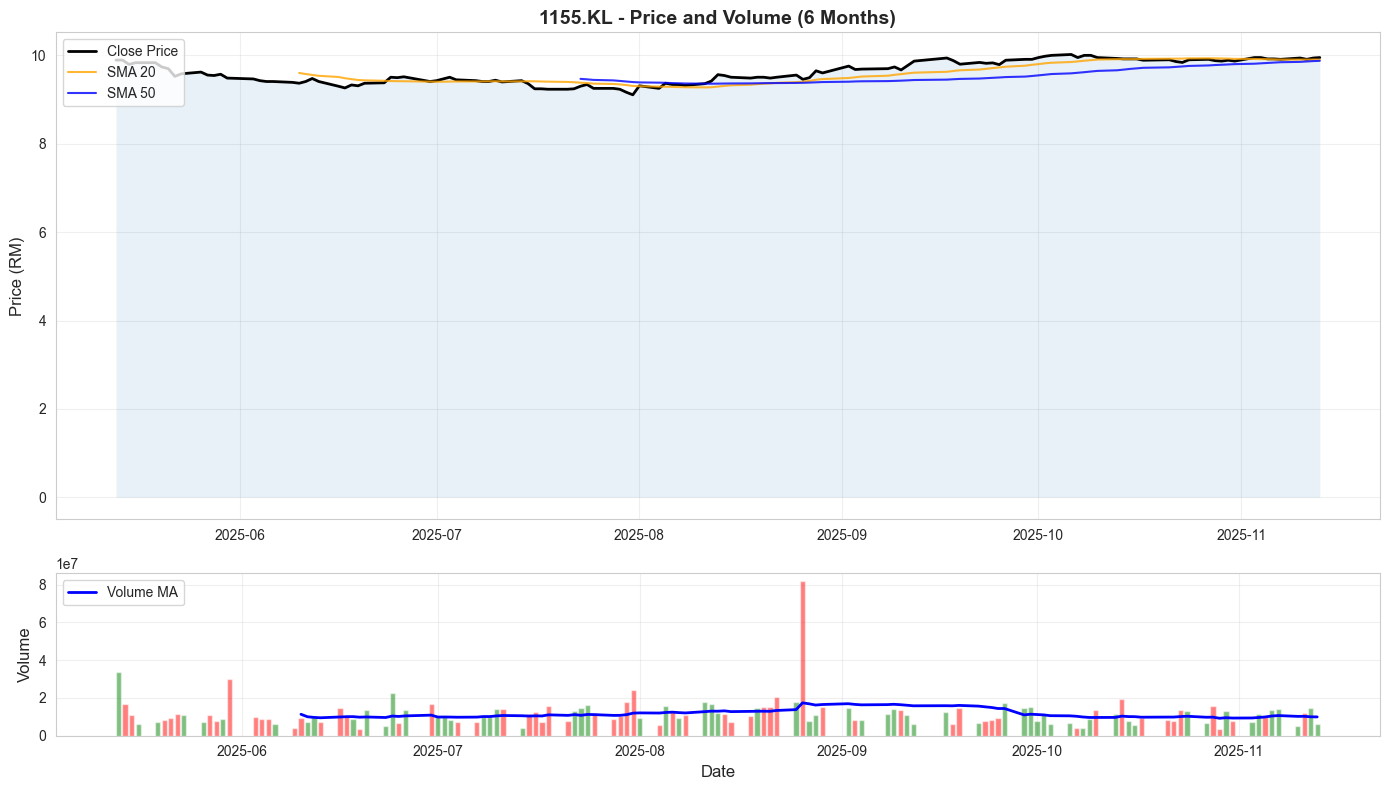


💡 Interpretation:
  • Price above SMA = Uptrend
  • Price below SMA = Downtrend
  • Green volume bars = Buying pressure
  • Red volume bars = Selling pressure


In [18]:
# Create a price chart with volume using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

# Price chart
ax1.plot(df_viz.index, df_viz['Close'], label='Close Price', color='black', linewidth=2)
ax1.plot(df_viz.index, df_viz['SMA_20'], label='SMA 20', color='orange', linewidth=1.5, alpha=0.8)
ax1.plot(df_viz.index, df_viz['SMA_50'], label='SMA 50', color='blue', linewidth=1.5, alpha=0.8)
ax1.fill_between(df_viz.index, df_viz['Close'], alpha=0.1)
ax1.set_ylabel('Price (RM)', fontsize=12)
ax1.set_title(f'{ticker} - Price and Volume (6 Months)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Volume chart
colors = ['green' if df_viz['Close'][i] >= df_viz['Open'][i] else 'red' 
          for i in range(len(df_viz))]
ax2.bar(df_viz.index, df_viz['Volume'], color=colors, alpha=0.5)
ax2.plot(df_viz.index, df_viz['Volume_SMA'], color='blue', linewidth=2, label='Volume MA')
ax2.set_ylabel('Volume', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  • Price above SMA = Uptrend")
print("  • Price below SMA = Downtrend")
print("  • Green volume bars = Buying pressure")
print("  • Red volume bars = Selling pressure")

## 7. Technical Analysis Visualization

Let's visualize our technical indicators to identify trading signals.

In [19]:
# Create comprehensive technical analysis dashboard
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=('Price with Bollinger Bands', 'RSI', 'MACD'),
    vertical_spacing=0.05,
    row_heights=[0.5, 0.25, 0.25]
)

# 1. Price with Bollinger Bands
fig.add_trace(go.Scatter(
    x=df_viz.index, y=df_viz['Close'],
    name='Close',
    line=dict(color='black', width=2)
), row=1, col=1)

if 'BBU_20_2.0' in df_viz.columns:
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['BBU_20_2.0'],
        name='Upper BB',
        line=dict(color='gray', width=1, dash='dash')
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['BBM_20_2.0'],
        name='Middle BB',
        line=dict(color='blue', width=1)
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['BBL_20_2.0'],
        name='Lower BB',
        line=dict(color='gray', width=1, dash='dash'),
        fill='tonexty'
    ), row=1, col=1)

# 2. RSI
fig.add_trace(go.Scatter(
    x=df_viz.index, y=df_viz['RSI'],
    name='RSI',
    line=dict(color='purple', width=2)
), row=2, col=1)

# Add RSI reference lines
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

# 3. MACD
if 'MACD_12_26_9' in df_viz.columns:
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['MACD_12_26_9'],
        name='MACD',
        line=dict(color='blue', width=2)
    ), row=3, col=1)
    
    fig.add_trace(go.Scatter(
        x=df_viz.index, y=df_viz['MACDs_12_26_9'],
        name='Signal',
        line=dict(color='orange', width=2)
    ), row=3, col=1)
    
    if 'MACDh_12_26_9' in df_viz.columns:
        colors = ['green' if val >= 0 else 'red' for val in df_viz['MACDh_12_26_9']]
        fig.add_trace(go.Bar(
            x=df_viz.index, y=df_viz['MACDh_12_26_9'],
            name='Histogram',
            marker_color=colors
        ), row=3, col=1)

# Update layout
fig.update_layout(
    title=f'{ticker} - Technical Analysis Dashboard',
    height=900,
    showlegend=True,
    hovermode='x unified'
)

fig.update_yaxes(title_text="Price (RM)", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)
fig.update_yaxes(title_text="MACD", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.show()

print("\n📊 Technical Analysis Dashboard created!")
print("\n💡 How to interpret:")
print("  Bollinger Bands:")
print("    • Price near upper band = Potentially overbought")
print("    • Price near lower band = Potentially oversold")
print("  RSI:")
print("    • Above 70 = Overbought (red line)")
print("    • Below 30 = Oversold (green line)")
print("  MACD:")
print("    • Blue line crosses above orange = Bullish signal")
print("    • Blue line crosses below orange = Bearish signal")


📊 Technical Analysis Dashboard created!

💡 How to interpret:
  Bollinger Bands:
    • Price near upper band = Potentially overbought
    • Price near lower band = Potentially oversold
  RSI:
    • Above 70 = Overbought (red line)
    • Below 30 = Oversold (green line)
  MACD:
    • Blue line crosses above orange = Bullish signal
    • Blue line crosses below orange = Bearish signal


## 8. Portfolio Tracking

Let's create a portfolio tracker to monitor multiple stocks and calculate returns.

We'll build a sample portfolio and track its performance over time.

In [20]:
# Define a sample portfolio
portfolio = {
    '1155.KL': {'name': 'Maybank', 'shares': 1000, 'buy_price': 9.00},
    '1295.KL': {'name': 'Public Bank', 'shares': 500, 'buy_price': 4.50},
    '5296.KL': {'name': 'Tenaga', 'shares': 300, 'buy_price': 12.00},
    '1023.KL': {'name': 'CIMB', 'shares': 800, 'buy_price': 5.50},
    '5183.KL': {'name': 'Petronas Chemicals', 'shares': 200, 'buy_price': 7.80}
}

print("📋 PORTFOLIO HOLDINGS")
print("="*80)
print(f"{'Stock':<20} {'Shares':>10} {'Buy Price':>12} {'Cost':>15}")
print("-"*80)

total_cost = 0
for ticker, data in portfolio.items():
    cost = data['shares'] * data['buy_price']
    total_cost += cost
    print(f"{data['name']:<20} {data['shares']:>10} RM {data['buy_price']:>9.2f} RM {cost:>12,.2f}")

print("-"*80)
print(f"{'TOTAL INVESTMENT':<44} RM {total_cost:>12,.2f}")
print("="*80)

📋 PORTFOLIO HOLDINGS
Stock                    Shares    Buy Price            Cost
--------------------------------------------------------------------------------
Maybank                    1000 RM      9.00 RM     9,000.00
Public Bank                 500 RM      4.50 RM     2,250.00
Tenaga                      300 RM     12.00 RM     3,600.00
CIMB                        800 RM      5.50 RM     4,400.00
Petronas Chemicals          200 RM      7.80 RM     1,560.00
--------------------------------------------------------------------------------
TOTAL INVESTMENT                             RM    20,810.00


In [21]:
# Fetch current prices and calculate portfolio value
print("Fetching current prices...\n")

portfolio_data = []

for ticker, data in portfolio.items():
    stock = yf.Ticker(ticker)
    info = stock.info
    
    current_price = info.get('currentPrice') or info.get('regularMarketPrice')
    
    if current_price:
        shares = data['shares']
        buy_price = data['buy_price']
        
        cost = shares * buy_price
        current_value = shares * current_price
        gain_loss = current_value - cost
        gain_loss_pct = (gain_loss / cost) * 100
        
        portfolio_data.append({
            'Ticker': ticker,
            'Name': data['name'],
            'Shares': shares,
            'Buy Price': buy_price,
            'Current Price': current_price,
            'Cost': cost,
            'Current Value': current_value,
            'Gain/Loss': gain_loss,
            'Return (%)': gain_loss_pct
        })

# Create portfolio DataFrame
portfolio_df = pd.DataFrame(portfolio_data)

print("📊 CURRENT PORTFOLIO STATUS")
print("="*80)
print(portfolio_df[['Name', 'Shares', 'Buy Price', 'Current Price', 'Return (%)']].to_string(index=False))

# Calculate totals
total_cost = portfolio_df['Cost'].sum()
total_value = portfolio_df['Current Value'].sum()
total_gain_loss = total_value - total_cost
total_return_pct = (total_gain_loss / total_cost) * 100

print("\n" + "="*80)
print(f"Total Investment:    RM {total_cost:>12,.2f}")
print(f"Current Value:       RM {total_value:>12,.2f}")
print(f"Total Gain/Loss:     RM {total_gain_loss:>12,.2f}")
print(f"Portfolio Return:    {total_return_pct:>12.2f}%")
print("="*80)

# Determine status
if total_return_pct > 0:
    status = "🟢 PROFIT"
elif total_return_pct < 0:
    status = "🔴 LOSS"
else:
    status = "🟡 BREAK-EVEN"

print(f"\nPortfolio Status: {status}")

Fetching current prices...



📊 CURRENT PORTFOLIO STATUS
              Name  Shares  Buy Price  Current Price  Return (%)
           Maybank    1000        9.0           9.95   10.555556
       Public Bank     500        4.5           4.30   -4.444444
            Tenaga     300       12.0           1.59  -86.750000
              CIMB     800        5.5           7.57   37.636364
Petronas Chemicals     200        7.8           3.50  -55.128205

Total Investment:    RM    20,810.00
Current Value:       RM    19,333.00
Total Gain/Loss:     RM    -1,477.00
Portfolio Return:           -7.10%

Portfolio Status: 🔴 LOSS


In [22]:
# Visualize portfolio allocation
fig = px.pie(
    portfolio_df,
    values='Current Value',
    names='Name',
    title='Portfolio Allocation by Current Value',
    hole=0.4
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

print("\n💡 This shows how your portfolio is distributed across different stocks.")


💡 This shows how your portfolio is distributed across different stocks.


In [23]:
# Visualize individual stock performance
fig = px.bar(
    portfolio_df,
    x='Name',
    y='Return (%)',
    title='Individual Stock Returns',
    color='Return (%)',
    color_continuous_scale=['red', 'yellow', 'green'],
    text='Return (%)'
)

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(yaxis_title="Return (%)", xaxis_title="Stock")
fig.add_hline(y=0, line_dash="dash", line_color="black")
fig.show()

print("\n💡 Green bars = profitable stocks, Red bars = losing stocks")


💡 Green bars = profitable stocks, Red bars = losing stocks


## 9. Sector & Comparative Analysis

Let's analyze stocks by sector and compare their performance.

In [24]:
# Group stocks by sector
if len(stocks_df) > 0:
    print("📊 SECTOR ANALYSIS")
    print("="*80)
    
    # Count stocks by sector
    sector_counts = stocks_df['Sector'].value_counts()
    print("\nNumber of stocks per sector:")
    print(sector_counts)
    
    # Average metrics by sector
    print("\n" + "="*80)
    print("Average metrics by sector:\n")
    
    sector_stats = stocks_df.groupby('Sector').agg({
        'Market Cap (B)': 'mean',
        'PE Ratio': 'mean',
        'Dividend Yield (%)': 'mean'
    }).round(2)
    
    print(sector_stats)

📊 SECTOR ANALYSIS

Number of stocks per sector:
Sector
Financial Services        4
Communication Services    3
Consumer Defensive        3
Industrials               3
N/A                       2
Consumer Cyclical         2
Basic Materials           1
Healthcare                1
Name: count, dtype: int64

Average metrics by sector:

                        Market Cap (B)  PE Ratio  Dividend Yield (%)
Sector                                                              
Basic Materials                  28.00       NaN              170.00
Communication Services           34.24     21.97              381.00
Consumer Cyclical                14.59     16.70              504.50
Consumer Defensive               22.74     14.89              363.33
Financial Services               78.83     10.83              563.00
Healthcare                       72.90     33.00              121.00
Industrials                      19.57     25.52              372.50
N/A                                NaN       

In [25]:
# Visualize sector distribution
if len(stocks_df) > 0:
    sector_counts = stocks_df['Sector'].value_counts()
    
    fig = px.pie(
        values=sector_counts.values,
        names=sector_counts.index,
        title='Stock Distribution by Sector'
    )
    
    fig.show()

In [26]:
# Compare banking stocks
print("🏦 BANKING SECTOR COMPARISON")
print("="*80)

banking_tickers = ['1155.KL', '1295.KL', '1023.KL', '6947.KL', '1066.KL']
banking_names = ['Maybank', 'Public Bank', 'CIMB', 'RHB Bank', 'Hong Leong Bank']

# Fetch 6-month performance for all banks
banking_performance = []

for ticker, name in zip(banking_tickers, banking_names):
    hist = get_stock_data(ticker, period="6mo")
    if hist is not None and len(hist) > 0:
        start_price = hist['Close'].iloc[0]
        end_price = hist['Close'].iloc[-1]
        return_pct = ((end_price / start_price) - 1) * 100
        
        banking_performance.append({
            'Bank': name,
            'Ticker': ticker,
            'Start Price': start_price,
            'Current Price': end_price,
            '6M Return (%)': return_pct
        })

banking_df = pd.DataFrame(banking_performance)

if len(banking_df) > 0:
    print("\n6-Month Performance Comparison:\n")
    print(banking_df[['Bank', 'Current Price', '6M Return (%)']].sort_values('6M Return (%)', ascending=False).to_string(index=False))
    
    # Visualize
    fig = px.bar(
        banking_df.sort_values('6M Return (%)'),
        x='6M Return (%)',
        y='Bank',
        orientation='h',
        title='Banking Sector - 6-Month Returns Comparison',
        color='6M Return (%)',
        color_continuous_scale=['red', 'yellow', 'green']
    )
    
    fig.add_vline(x=0, line_dash="dash", line_color="black")
    fig.show()

🏦 BANKING SECTOR COMPARISON


✅ Fetched 126 days of data for 1155.KL


✅ Fetched 126 days of data for 1295.KL


✅ Fetched 126 days of data for 1023.KL
✅ Fetched 126 days of data for 6947.KL


✅ Fetched 126 days of data for 1066.KL

6-Month Performance Comparison:

           Bank  Current Price  6M Return (%)
           CIMB           7.57       6.349872
Hong Leong Bank           6.90       3.525876
        Maybank           9.95       0.575362
    Public Bank           4.30      -2.052702
       RHB Bank           3.62      -5.284261


📈 BENCHMARK COMPARISON: Stock vs KLSE Index
✅ Fetched 245 days of data for ^KLSE
✅ Fetched 245 days of data for 1155.KL


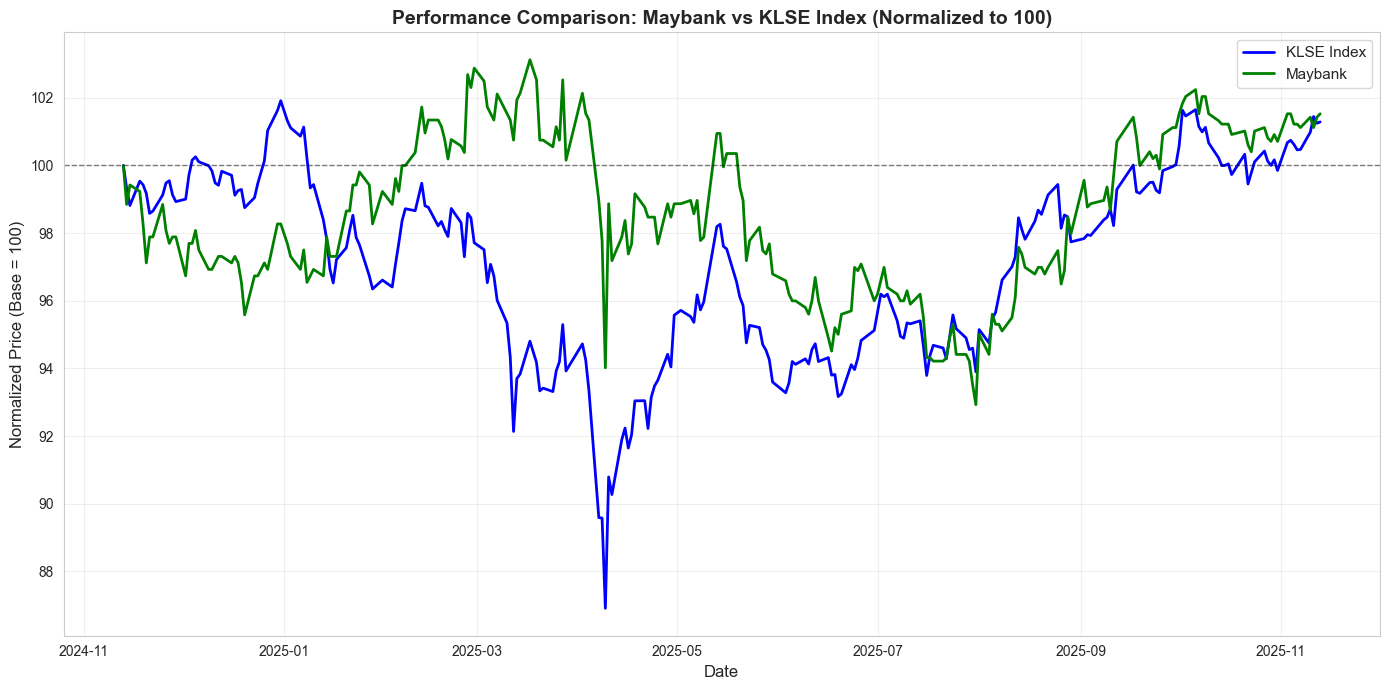


1-Year Returns:
  KLSE Index: 1.29%
  Maybank:    1.53%
  Difference: +0.24%

✅ Maybank OUTPERFORMED the index by 0.24%


In [27]:
# Benchmark against KLSE index
print("📈 BENCHMARK COMPARISON: Stock vs KLSE Index")
print("="*80)

# Fetch KLSE index data
klse_index = get_stock_data("^KLSE", period="1y")
maybank_data = get_stock_data("1155.KL", period="1y")

if klse_index is not None and maybank_data is not None:
    # Normalize prices to 100 for comparison
    klse_normalized = (klse_index['Close'] / klse_index['Close'].iloc[0]) * 100
    maybank_normalized = (maybank_data['Close'] / maybank_data['Close'].iloc[0]) * 100
    
    # Plot comparison
    plt.figure(figsize=(14, 7))
    plt.plot(klse_normalized.index, klse_normalized, label='KLSE Index', linewidth=2, color='blue')
    plt.plot(maybank_normalized.index, maybank_normalized, label='Maybank', linewidth=2, color='green')
    plt.axhline(y=100, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.title('Performance Comparison: Maybank vs KLSE Index (Normalized to 100)', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Price (Base = 100)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate relative performance
    klse_return = ((klse_normalized.iloc[-1] / 100) - 1) * 100
    maybank_return = ((maybank_normalized.iloc[-1] / 100) - 1) * 100
    outperformance = maybank_return - klse_return
    
    print(f"\n1-Year Returns:")
    print(f"  KLSE Index: {klse_return:.2f}%")
    print(f"  Maybank:    {maybank_return:.2f}%")
    print(f"  Difference: {outperformance:+.2f}%")
    
    if outperformance > 0:
        print(f"\n✅ Maybank OUTPERFORMED the index by {outperformance:.2f}%")
    else:
        print(f"\n❌ Maybank UNDERPERFORMED the index by {abs(outperformance):.2f}%")

## 10. Data Export & Caching

To avoid repeatedly fetching data from APIs (and to be respectful of rate limits), we'll implement caching.

This will:
- Save fetched data to CSV files
- Load cached data when available
- Only refresh data when needed

In [28]:
# Create data directory if it doesn't exist
DATA_DIR = 'data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    print(f"✅ Created '{DATA_DIR}' directory")
else:
    print(f"✅ '{DATA_DIR}' directory exists")

✅ 'data' directory exists


In [29]:
# Function to save stock data
def save_stock_data(ticker, df, data_dir='data'):
    """
    Save stock price data to CSV.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker
    df : pd.DataFrame
        Stock price data
    data_dir : str
        Directory to save data
    """
    filename = f"{data_dir}/{ticker.replace('.', '_')}_prices.csv"
    df.to_csv(filename)
    print(f"✅ Saved {ticker} data to {filename}")

# Function to load stock data
def load_stock_data(ticker, data_dir='data'):
    """
    Load stock price data from CSV.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker
    data_dir : str
        Directory containing data
    
    Returns:
    --------
    pd.DataFrame or None
        Stock price data or None if file doesn't exist
    """
    filename = f"{data_dir}/{ticker.replace('.', '_')}_prices.csv"
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col=0, parse_dates=True)
        print(f"✅ Loaded {ticker} data from {filename}")
        return df
    else:
        print(f"⚠️  No cached data found for {ticker}")
        return None

print("✅ save_stock_data() and load_stock_data() functions created!")

✅ save_stock_data() and load_stock_data() functions created!


In [30]:
# Test saving and loading
print("🧪 Testing data caching:\n")

ticker = "1155.KL"

# Fetch fresh data
fresh_data = get_stock_data(ticker, period="3mo")

if fresh_data is not None:
    # Save it
    save_stock_data(ticker, fresh_data)
    
    # Try loading it back
    loaded_data = load_stock_data(ticker)
    
    if loaded_data is not None:
        print(f"\n✅ Successfully saved and loaded data!")
        print(f"   Rows in original: {len(fresh_data)}")
        print(f"   Rows in loaded:   {len(loaded_data)}")

🧪 Testing data caching:

✅ Fetched 62 days of data for 1155.KL
✅ Saved 1155.KL data to data/1155_KL_prices.csv
✅ Loaded 1155.KL data from data/1155_KL_prices.csv

✅ Successfully saved and loaded data!
   Rows in original: 62
   Rows in loaded:   62


In [31]:
# Save fundamental data
if len(stocks_df) > 0:
    fundamentals_file = f"{DATA_DIR}/klse_fundamentals.csv"
    stocks_df.to_csv(fundamentals_file, index=False)
    print(f"✅ Saved fundamental data for {len(stocks_df)} stocks to {fundamentals_file}")
    
    # Add timestamp
    metadata_file = f"{DATA_DIR}/last_updated.txt"
    with open(metadata_file, 'w') as f:
        f.write(f"Last updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"✅ Saved metadata to {metadata_file}")

✅ Saved fundamental data for 19 stocks to data/klse_fundamentals.csv
✅ Saved metadata to data/last_updated.txt


## 11. Summary & Next Steps

Congratulations! You've built a comprehensive KLSE stock screener and analyzer! 🎉

### ✅ What You've Learned:

1. **Data Acquisition**:
   - Fetching Malaysian stock data using yfinance
   - Understanding OHLCV (Open, High, Low, Close, Volume) data
   - Working with Yahoo Finance API

2. **Fundamental Analysis**:
   - Extracting company information and financial metrics
   - Understanding PE ratio, market cap, dividend yield
   - Comparing companies across sectors

3. **Technical Analysis**:
   - Calculating moving averages (SMA 20, 50, 200)
   - Computing RSI (Relative Strength Index)
   - Understanding MACD signals
   - Working with Bollinger Bands

4. **Stock Screening**:
   - Building custom filters for value investing
   - Identifying large-cap stocks
   - Screening by sector and fundamentals

5. **Portfolio Management**:
   - Tracking multiple stock positions
   - Calculating portfolio returns
   - Visualizing portfolio allocation

6. **Data Visualization**:
   - Creating interactive candlestick charts
   - Building technical analysis dashboards
   - Comparing sector performance

7. **Data Management**:
   - Saving and loading data
   - Implementing caching to reduce API calls

---

### 🎯 Ideas for Further Development:

#### **1. Enhanced Screening**
- Add more screening criteria (earnings growth, debt-to-equity ratio)
- Implement multi-factor scoring system
- Create sector rotation strategies

#### **2. Advanced Technical Analysis**
- Add Fibonacci retracement levels
- Implement pattern recognition (head & shoulders, double tops)
- Create custom trading signals

#### **3. Portfolio Optimization**
- Calculate Sharpe ratio and other risk metrics
- Implement portfolio diversification analysis
- Add correlation analysis between stocks

#### **4. Alerts & Automation**
- Set price alerts for specific stocks
- Create automated daily/weekly reports
- Send email notifications for screener results

#### **5. Machine Learning**
- Predict stock prices using LSTM networks
- Build classification models for buy/sell signals
- Implement sentiment analysis from news

#### **6. Web Dashboard**
- Build interactive dashboard with Streamlit
- Create web app with Flask/Django
- Deploy to cloud (Heroku, AWS, etc.)

#### **7. More Data Sources**
- Integrate Bursa Malaysia official data
- Add company announcements tracking
- Include economic indicators (GDP, interest rates)

---

### 📚 Recommended Learning Resources:

**Python Libraries:**
- [yfinance Documentation](https://pypi.org/project/yfinance/)
- [pandas-ta Documentation](https://github.com/twopirllc/pandas-ta)
- [Plotly Documentation](https://plotly.com/python/)

**Technical Analysis:**
- [Investopedia - Technical Analysis](https://www.investopedia.com/technical-analysis-4689657)
- [StockCharts - ChartSchool](https://school.stockcharts.com/)

**Malaysian Market:**
- [Bursa Malaysia](https://www.bursamalaysia.com/)
- [The Edge Markets](https://www.theedgemarkets.com/)
- [i3investor](https://klse.i3investor.com/)

**Data Science:**
- [Kaggle Learn](https://www.kaggle.com/learn)
- [DataCamp](https://www.datacamp.com/)

---

### ⚠️ Important Disclaimers:

1. **Not Financial Advice**: This project is for educational purposes only. Always do your own research and consult with licensed financial advisors before making investment decisions.

2. **Data Accuracy**: While yfinance is generally reliable, always verify critical data against official sources.

3. **Past Performance**: Historical returns do not guarantee future results.

4. **Risk Warning**: Stock market investing carries risk. Never invest more than you can afford to lose.

5. **API Usage**: Be respectful of API rate limits. Excessive requests may result in temporary bans.

---

### 💡 Practice Exercises:

1. **Modify the screener** to find high-growth technology stocks
2. **Create your own portfolio** and track it for 1 month
3. **Backtest a strategy** using historical data
4. **Compare different sectors** during market downturns
5. **Build a watchlist** of 10 stocks and monitor them daily
6. **Analyze correlations** between banking stocks
7. **Create a dividend tracker** for income-focused portfolios

---

**Happy Investing & Analyzing! 📈🚀**

Remember: Knowledge + Discipline + Patience = Success in the stock market!